In [1]:
%%capture
!pip install timm torchsummary tqdm

In [2]:
import os
import cv2
import random
import tarfile
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
np.random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Setting up the GPU/CPU
will depend on the selected runtime for colab

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Extracting images to local storage

!rm -r /content/Dataset

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/Dataset.tar.xz')
my_tar.extractall()
my_tar.close()

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/data_bordered.tar.xz')
my_tar.extractall()
my_tar.close()

# Create image path lists

In [5]:
original_image_path = '/content/Dataset/1.training/1.training'
constant_image_path = '/content/data_border_constant'
reflect_image_path = '/content/data_border_reflect'

In [6]:
# creating a 2d list where the first list contains path of images
# the second list contains a flag denoting whether the image is from original set or bordered
# and the third list contains one-hot encoded label vectors
image_path_list = []

In [7]:
def img_list(data_path):
  # getting list of all the images
  path_list = []
  images = os.listdir(data_path)
  #exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    #print(list(map(int, i[-13:-4].strip('][').split(', '))))
    if 'DS_S' in str(i):
      continue
    path_list.append([data_path + '/' + str(i), list(map(int, i[-13:-4].strip('][').split(', ')))])
  
  return path_list

In [8]:
# loading image paths
original_list = img_list(original_image_path)
const_list = img_list(constant_image_path)
refl_list = img_list(reflect_image_path)

In [9]:
print(len(original_list), len(const_list), len(refl_list))

10091 10091 10091


In [10]:
original_list = [x for x in original_list if ('[1, 0, 0]' in x[0]) or\
                                             ('[0, 1, 0]' in x[0]) or\
                                             ('[0, 0, 1]' in x[0]) or\
                                             ('[1, 1, 0]' in x[0])
                                             ]

const_list = [x for x in const_list if ('[1, 0, 0]' in x[0]) or\
                                       ('[0, 1, 0]' in x[0]) or\
                                       ('[0, 0, 1]' in x[0])]

refl_list = [x for x in refl_list if ('[1, 0, 0]' in x[0]) or\
                                     ('[0, 1, 0]' in x[0]) or\
                                     ('[0, 0, 1]' in x[0])]

In [11]:
print(len(original_list), len(const_list), len(refl_list))

10086 4693 4693


In [12]:
image_path_list.extend(original_list)
image_path_list.extend(const_list)
image_path_list.extend(refl_list)

In [13]:
len(image_path_list)

19472

In [14]:
#train_list, test_list = train_test_split(image_path_list, test_size = 0.2, train_size = 0.8)

In [15]:
#len(train_list)

In [16]:
#len(test_list)

# Creating the dataset class

In [17]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    labels = self.image_list[idx][1]
    labels = np.array([labels])
    #labels = labels.astype('int').reshape(-1, 3) #.argmax(axis=1)        # reshapes the labels array into (n, 3) array
    labels = labels.astype('float32').reshape(-1)
    #sample = {'image': image, 'labels': labels}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
    
    return image, labels

19472
0 (182, 294, 3) (3,)
1 (216, 294, 3) (3,)
2 (211, 204, 3) (3,)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


3 (254, 278, 3) (3,)


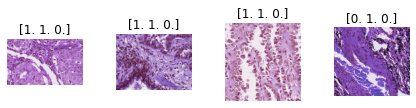

In [18]:
# check if the dataloader works
check_loader = LUAD(image_list=image_path_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, labels = check_loader[i]

    print(i, image.shape, labels.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.set_title(labels)
    ax.axis('off')
    #plt.imshow(sample['image'])
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

In [19]:
random_augs = ([#transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
               #transforms.RandomGrayscale(p=0.1),            #Grayscale(num_output_channels=3),
               #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
               #transforms.RandomHorizontalFlip(p=0.5),
               #transforms.RandomVerticalFlip(p=0.5),
               #transforms.RandomRotation(30),
               transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
               #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
               #transforms.RandomAdjustSharpness(sharpness_factor=2),
               ])

# creatin the train dataset
train_dataset = LUAD(image_path_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     transforms.RandomRotation(30),
                                                     transforms.RandomVerticalFlip(p=0.5),
                                                     transforms.RandomHorizontalFlip(p=0.5),
                                                     transforms.RandomApply(random_augs, p=0.4),
                                                     transforms.Normalize([0.698, 0.535, 0.768], [0.134, 0.192, 0.149]),]
                                                     ))

In [20]:
batch_size = 64

In [21]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 1,
                              )

In [22]:
len(train_dataloader)

305

# Creating the Model

In [23]:
#model_vit_base_patch32_224 = timm.create_model('vit_base_patch32_224', pretrained = True, num_classes = 3,
#                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)
#print(model(torch.randn(1, 3, 224, 224)))

model_vit_base_patch32_224 = timm.create_model('vit_large_patch32_224_in21k', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

In [24]:
model_vit_base_patch32_224

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.2, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.2, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.2, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.2, inplace=False)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2): Dropout(p=0.2, inplace=False)
      )
     

In [25]:
torchsummary.summary(model_vit_base_patch32_224, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 1024, 7, 7]       3,146,752
          Identity-2             [-1, 49, 1024]               0
        PatchEmbed-3             [-1, 49, 1024]               0
           Dropout-4             [-1, 50, 1024]               0
         LayerNorm-5             [-1, 50, 1024]           2,048
            Linear-6             [-1, 50, 3072]       3,148,800
           Dropout-7           [-1, 16, 50, 50]               0
            Linear-8             [-1, 50, 1024]       1,049,600
           Dropout-9             [-1, 50, 1024]               0
        Attention-10             [-1, 50, 1024]               0
         Identity-11             [-1, 50, 1024]               0
         Identity-12             [-1, 50, 1024]               0
        LayerNorm-13             [-1, 50, 1024]           2,048
           Linear-14             [-1, 5

## Checking model properties

In [26]:
next(model_vit_base_patch32_224.parameters()).is_cuda

True

In [27]:
y_pred = model_vit_base_patch32_224(torch.randn(2, 3, 224, 224).to(device))
y_pred

tensor([[ 0.0790,  0.0088, -0.1627],
        [-0.1708,  0.1219, -0.1700]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [28]:
y_pred.argmax(axis=1)

tensor([0, 1], device='cuda:0')

In [29]:
y_p = nn.functional.softmax(y_pred, dim=-1)
y_p

tensor([[0.3680, 0.3430, 0.2890],
        [0.2993, 0.4011, 0.2996]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [30]:
y_p.argmax(axis=1)

tensor([0, 1], device='cuda:0')

y_pred

y_pred.shape

type(y_pred)

y_pred.argmax(axis=1)

y = np.array([[0, 1, 0], [1, 0, 1]])

torch.from_numpy(y)

y.shape

nn.CrossEntropyLoss()(y_pred, torch.from_numpy(y.argmax(axis=1)))

for i_batch, (x, y) in enumerate(test_dataloader):
  print(x.shape, y.shape)
  print(len(y.argmax(axis=1)))
  model_vit_base_patch32_224(x.to(device))

  if i_batch == 0:
    break

model_vit_base_patch32_224(torch.randn(32, 3, 224, 224)).shape

# Defining Training and validation

In [31]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False,)
  for batch, (x, y) in loop:
    
    # send data to GPU
    x, y = x.to(device), y.to(device)

    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model(x)
    y_pred = torch.sigmoid(model_out).round()

    # calculate loss
    #loss = loss_fn(y_pred, y.argmax(axis=1))
    loss = loss_fn(model_out, y)
    #print(loss) Printed the loss per batch per epoch
    train_loss += loss
    train_acc += eval_fn(y.cpu().detach().numpy(),
                         y_pred.cpu().detach().numpy())

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      test_pred = nn.functional.softmax(model(X), dim = -1)
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(test_pred, y.argmax(axis=1))
      test_acc += eval_fn(y.cpu().argmax(axis=1),
                          test_pred.cpu().detach().numpy().argmax(axis=1))
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

# Training the model

In [32]:
#model_save_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/bor_ref_tum-str_vit_large_patch32_224_01.pth'
model_save_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/bor_ref_tum-str_vit_large_patch32_224_02.pth'

In [33]:
epochs = 20

In [34]:
valid_acc = -np.inf

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch+1} / {epochs}\n---------")
  train_step(data_loader=train_dataloader,
             model=model_vit_base_patch32_224,
             loss_fn=nn.MultiLabelSoftMarginLoss(),
             opt=Adam(model_vit_base_patch32_224.parameters(), lr=0.0001, ),   #weight_decay=0.01
             eval_fn=accuracy_score
             )
  '''
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model_vit_base_patch32_224,
                                  loss_fn=nn.CrossEntropyLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch32_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  '''

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.2680 | Train accuracy: 0.7536
Epoch: 2 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.1692 | Train accuracy: 0.8416
Epoch: 3 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.1436 | Train accuracy: 0.8624
Epoch: 4 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.1246 | Train accuracy: 0.8781
Epoch: 5 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.1148 | Train accuracy: 0.8865
Epoch: 6 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.1055 | Train accuracy: 0.8931
Epoch: 7 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.0983 | Train accuracy: 0.9007
Epoch: 8 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.0940 | Train accuracy: 0.9065
Epoch: 9 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.0880 | Train accuracy: 0.9092
Epoch: 10 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.0793 | Train accuracy: 0.9170
Epoch: 11 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.0766 | Train accuracy: 0.9200
Epoch: 12 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.0712 | Train accuracy: 0.9257
Epoch: 13 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.0703 | Train accuracy: 0.9291
Epoch: 14 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

Train loss: 0.0661 | Train accuracy: 0.9316
Epoch: 15 / 20
---------


  0%|          | 0/305 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [35]:
torch.save(obj = model_vit_base_patch32_224.state_dict(), f = model_save_path)